In [9]:
# Dependencies and Setup
#%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from statsmodels.formula.api import glm
import statsmodels.api as sm
import scipy.stats as stats

In [3]:
# Import data to convert text fields to categorical fields
data = pd.read_csv("train.csv")
data["ln_SalePrice"] = np.log(data["SalePrice"])
obj_list = data.select_dtypes('object').apply(pd.Series.nunique, axis = 0)
le = LabelEncoder()

for i in obj_list.index:
    try:
        le.fit(data[i])
        data[i] = le.transform(data[i])
    except:
        data[i] = pd.get_dummies(data[i])

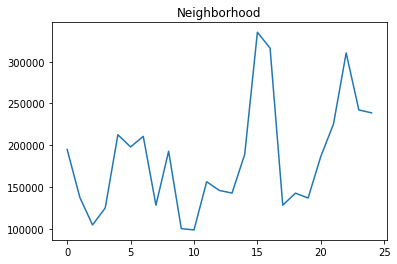

In [4]:
# Show the average target by selected fields (i)
i= 12
d1 = data.groupby(data.columns[i])
plt.plot(d1["SalePrice"].mean())
plt.title(data.columns[i])
plt.show()

In [26]:
# Create formula (form1) for use in linear models
a = data.columns[4]
b = data.columns[17]
c = data.columns[20]
d = data.columns[38]
e = data.columns[46]
f = data.columns[18]
g = data.columns[19]

form1 = "SalePrice ~ " + a + " + " +  b + " + " + c + " + " + d + " + " + e + " + " + f 
form2 = "ln_SalePrice ~ " + a + " + " +  b + " + " + c + " + " + d + " + " + e + " + " + f 
form2

'ln_SalePrice ~ LotArea + OverallQual + YearRemodAdd + TotalBsmtSF + GrLivArea + OverallCond'

In [30]:
# GLM consistent with Ordinary least squares
model_ols = glm(formula = form1, data = data, family = sm.families.Gaussian()).fit()
print(model_ols.summary())
model_ols_ln = glm(formula = form2, data = data, family = sm.families.Gaussian()).fit()
print(model_ols_ln.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              SalePrice   No. Observations:                 1460
Model:                            GLM   Df Residuals:                     1453
Model Family:                Gaussian   Df Model:                            6
Link Function:               identity   Scale:                      1.5247e+09
Method:                          IRLS   Log-Likelihood:                -17504.
Date:                Tue, 23 Jul 2019   Deviance:                   2.2154e+12
Time:                        21:22:35   Pearson chi2:                 2.22e+12
No. Iterations:                     3   Covariance Type:             nonrobust
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept    -1.045e+06   1.16e+05     -9.026      0.000   -1.27e+06   -8.18e+05
LotArea          0.6913      0.109      6.349 

Diff1 min: -526,861.28
Diff1 max: 286,847.45
Diff2 min: -1,770,585.49
Diff2 max: 222,326.20


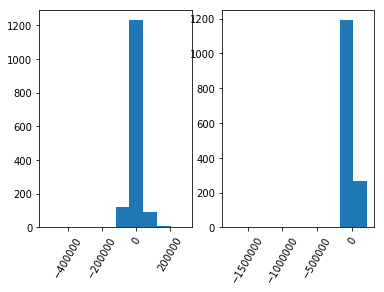

In [28]:
data["Pred1"] = model_ols.predict()
data["Diff1"] = data["SalePrice"] - data["Pred1"]
data["Pred2"] = np.exp(model_ols_ln.predict())
data["Diff2"] = data["SalePrice"] - data["Pred2"]
print("Diff1 min: " + "{:,.2f}".format(data["Diff1"].min()))
print("Diff1 max: " + "{:,.2f}".format(data["Diff1"].max()))
print("Diff2 min: " + "{:,.2f}".format(data["Diff2"].min()))
print("Diff2 max: " + "{:,.2f}".format(data["Diff2"].max()))

plt.subplot(1,2,1)
plt.hist(data["Diff1"])
plt.xticks(rotation = 60)
plt.subplot(1,2,2)
plt.hist(data["Diff2"])
plt.xticks(rotation = 60)
plt.show()

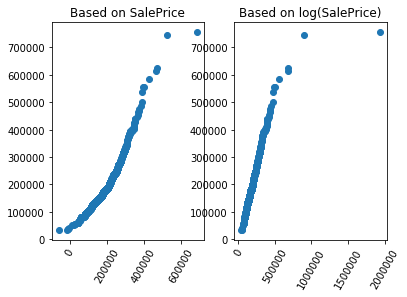

In [29]:
plt.subplot(1,2,1)
plt.scatter(np.sort(data["Pred1"]),np.sort(data["SalePrice"]))
plt.title("Based on SalePrice")
plt.xticks(rotation = 60)
plt.subplot(1,2,2)
plt.scatter(np.sort(data["Pred2"]),np.sort(data["SalePrice"]))
plt.title("Based on log(SalePrice)")
plt.xticks(rotation = 60)
plt.show()

In [103]:
data_model = data[["LotArea", "OverallQual", "YearRemodAdd", "TotalBsmtSF", "GrLivArea", "Neighborhood", "BldgType",
                   "SalePrice", "Pred1", "Diff1", "Pred2","Diff2"]]
outliers = data_model[data_model["Diff2"] < -500000]
outliers

,LotArea,OverallQual,YearRemodAdd,TotalBsmtSF,GrLivArea,Neighborhood,BldgType,SalePrice,Pred1,Diff1,Pred2,Diff2
523,40094,10,2008,3138,4676,7,0,184750,522692.062079,-337942.062079,8.841691e+05,-6.994191e+05
1298,63887,10,2008,6110,5642,7,0,160000,678046.123497,-518046.123497,1.812690e+06,-1.652690e+06


In [104]:
test = data_model[(data_model["Neighborhood"] == 7) & (data_model["OverallQual"] > 7)]
test

,LotArea,OverallQual,YearRemodAdd,TotalBsmtSF,GrLivArea,Neighborhood,BldgType,SalePrice,Pred1,Diff1,Pred2,Diff2
523,40094,10,2008,3138,4676,7,0,184750,522692.062079,-337942.062079,8.841691e+05,-6.994191e+05
724,13286,9,2008,1698,1698,7,0,320000,298309.358557,21690.641443,3.097010e+05,1.029902e+04
1298,63887,10,2008,6110,5642,7,0,160000,678046.123497,-518046.123497,1.812690e+06,-1.652690e+06


In [12]:
stats.ttest_ind(data["SalePrice"],data["Pred1"], equal_var=False)

Ttest_indResult(statistic=-7.380999351624349e-14, pvalue=0.9999999999999412)

In [13]:
stats.ttest_ind(data["SalePrice"],data["Pred2"], equal_var=False)

Ttest_indResult(statistic=0.7198888475596702, pvalue=0.47165118439387965)